In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import seaborn as sns
import matplotlib.pyplot as plt
!pip install scikit-image
from skimage.color import rgb2lab, deltaE_cie76
from skimage.color import lab2rgb, rgb2gray
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans


from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from scipy.linalg import sqrtm
from skimage.transform import resize

2024-04-30 10:12:18.822857: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 10:12:19.009680: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 10:12:19.692791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 10:12:22.006430: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Ensure that GPU is available for training if you're using a GPU-based instance
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# Load the dataset
monet_files = glob('gan-getting-started/monet_jpg/*.jpg')
photo_files = glob('gan-getting-started/photo_jpg/*.jpg')

In [4]:
# Display the count of each type of images
print(f"Number of Monet paintings: {len(monet_files)}")
print(f"Number of photos: {len(photo_files)}")


Number of Monet paintings: 300
Number of photos: 7038


In [5]:
# Helper function to display images
def display_images(images, title=None):
    plt.figure(figsize=(10, 7))
    for i, img_path in enumerate(images[:9]):
        img = load_img(img_path)
        img = img_to_array(img) / 255.0
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

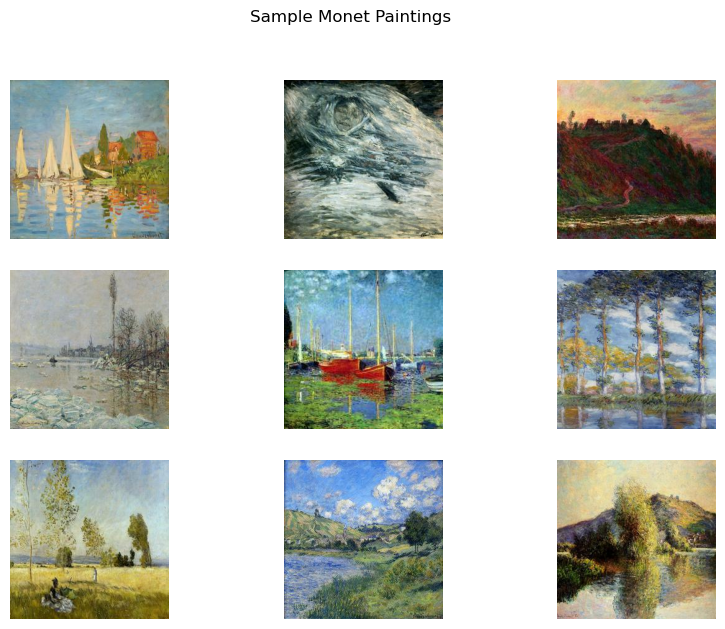

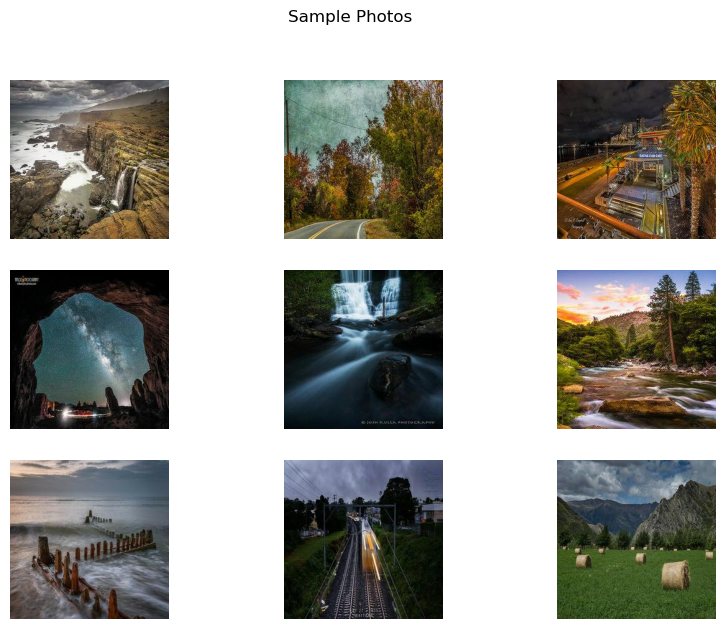

In [6]:
# Display some Monet paintings and photos
display_images(monet_files, "Sample Monet Paintings")
display_images(photo_files, "Sample Photos")

In [7]:
# Function to safely convert LAB to RGB
def safe_lab_to_rgb(l, a, b):
    lab = np.array([[l, a, b]]).reshape(1, 1, 3)
    rgb = lab2rgb(lab) * 255  # Convert LAB to RGB and scale to [0, 255]
    return rgb.astype(int)[0, 0, :]  # Return the RGB color as integers

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Figure size 1000x200 with 0 Axes>

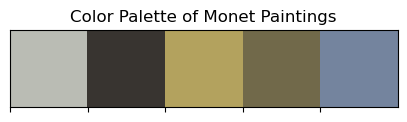

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Figure size 1000x200 with 0 Axes>

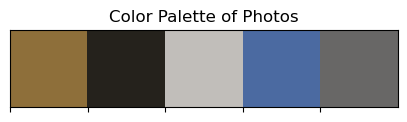

In [8]:
# Updated Color Distribution Analysis Function
def analyze_colors(image_paths, title):
    colors = []
    for img_path in image_paths:
        img = load_img(img_path)
        img = img_to_array(img)
        img = rgb2lab(img / 255.0)
        colors.extend(img.reshape(-1, 3))
    colors = np.array(colors)
    
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(colors)
    palette = kmeans.cluster_centers_

    # Convert LAB palette to RGB palette
    rgb_colors = [safe_lab_to_rgb(l, a, b) for l, a, b in palette]

    # Plot the colors using seaborn
    plt.figure(figsize=(10, 2))
    sns.palplot([tuple(color / 255.0 for color in rgb_color) for rgb_color in rgb_colors])
    plt.title(title)
    plt.show()

# Test the function
analyze_colors(monet_files[:100], "Color Palette of Monet Paintings")
analyze_colors(photo_files[:100], "Color Palette of Photos")

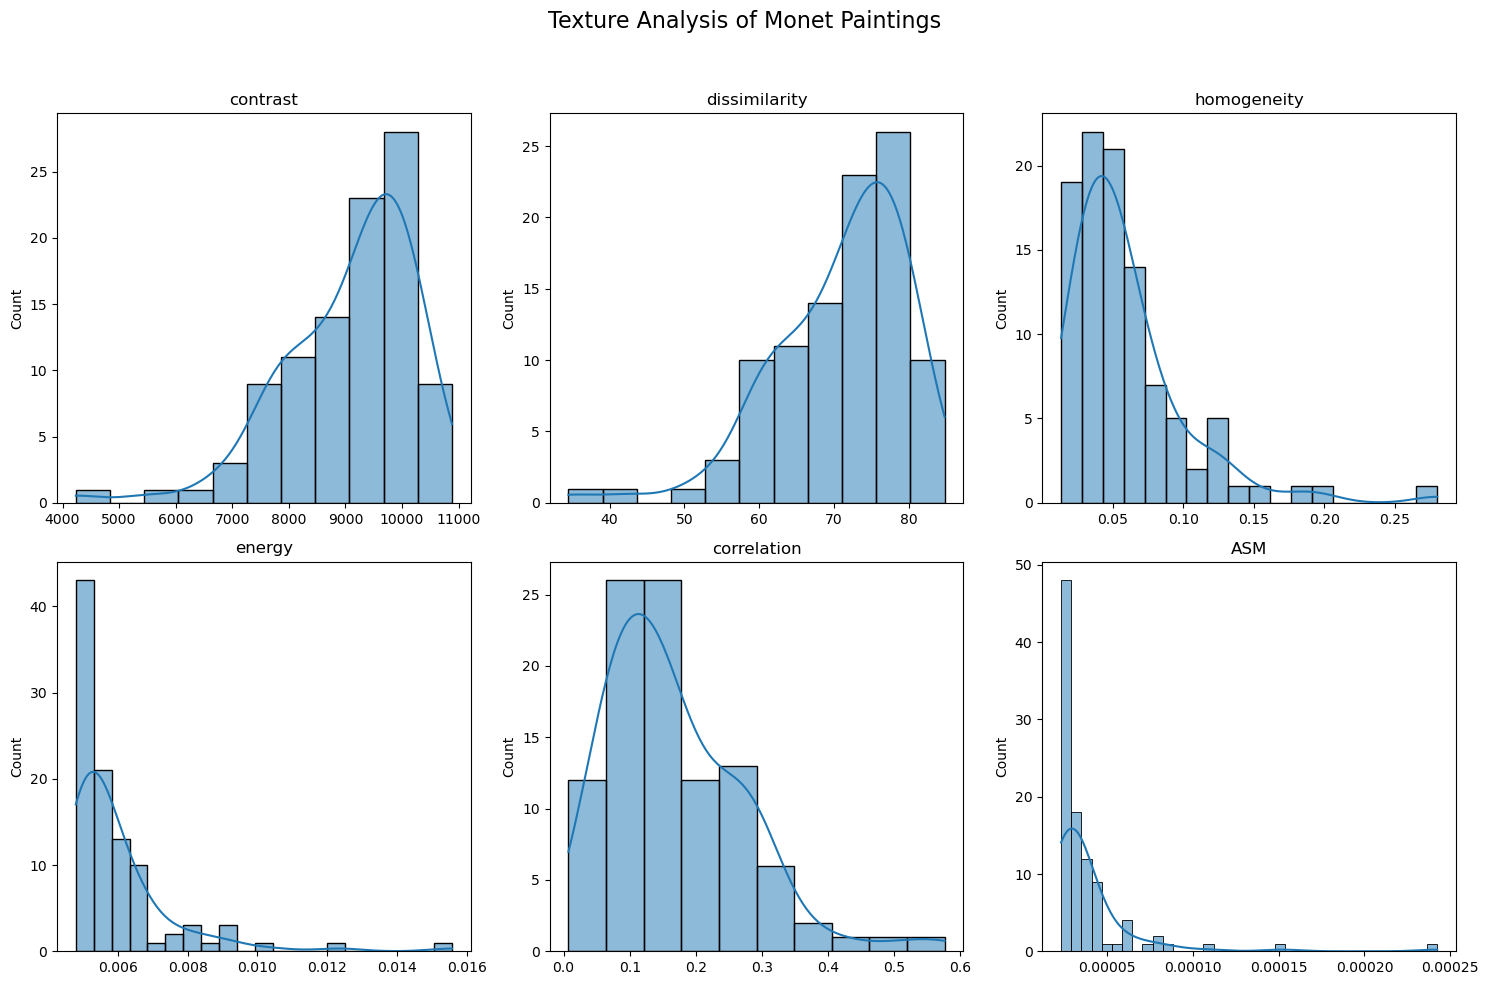

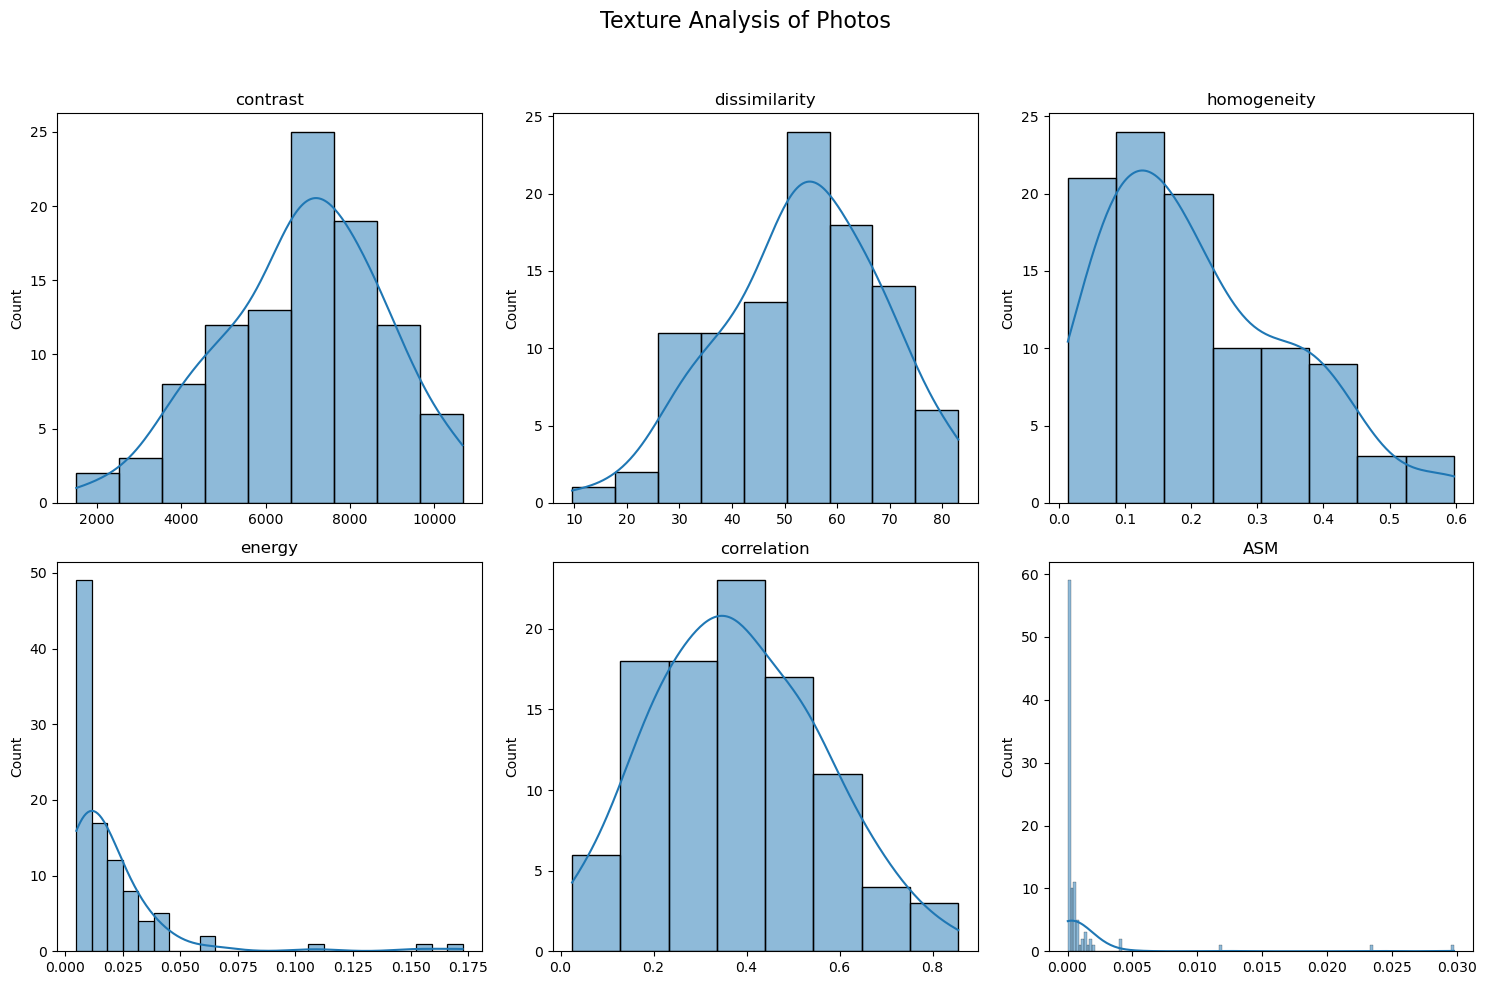

In [9]:
# Function to perform texture analysis on a set of images
def texture_analysis(image_paths, title):
    # Texture properties to analyze
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    texture_props = {prop: [] for prop in properties}
    
    # Process each image
    for img_path in image_paths:
        img = load_img(img_path)  # Load image
        img = img_to_array(img)   # Convert to array
        img = rgb2gray(img)       # Convert to grayscale
        img = (img * 255).astype(np.uint8)  # Scale the image to 0-255 and convert to uint8
        
        # Compute GLCM
        glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        
        # Compute properties from GLCM
        for prop in properties:
            result = graycoprops(glcm, prop)
            texture_props[prop].append(result[0, 0])
    
    # Plotting the results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    for i, prop in enumerate(properties):
        ax = axes[i // 3, i % 3]
        sns.histplot(texture_props[prop], kde=True, ax=ax)
        ax.set_title(prop)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage with a subset of images
texture_analysis(monet_files[:100], "Texture Analysis of Monet Paintings")
texture_analysis(photo_files[:100], "Texture Analysis of Photos")

In [10]:
# Constants
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 256, 256, 3
LATENT_DIM = 100
LEARNING_RATE = 0.0002
BETA_1 = 0.5

In [11]:
# Generator
def build_generator():
    model = Sequential([
        Dense(128 * 16 * 16, activation="relu", input_dim=LATENT_DIM),
        Reshape((16, 16, 128)),
        BatchNormalization(),
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', activation="relu"),
        BatchNormalization(),
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation="relu"),
        BatchNormalization(),
        Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation="relu"),
        BatchNormalization(),
        Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding='same', activation='tanh'),
    ])
    return model

In [12]:
# Discriminator
def build_discriminator():
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Conv2D(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Conv2D(256, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.25),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

In [13]:
# Load and preprocess the images
def load_images(image_paths, image_size=(IMG_HEIGHT, IMG_WIDTH)):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=image_size)
        img = img_to_array(img)
        img = (img - 127.5) / 127.5  # Normalize the images to [-1, 1]
        images.append(img)
    return np.array(images)

In [14]:
# GAN
def train_gan(generator, discriminator, data, epochs=1000, batch_size=32):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    for epoch in range(epochs):
        # Training the discriminator
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_imgs = data[idx]
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        generated_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, valid)
        d_loss_fake = discriminator.train_on_batch(generated_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Training the generator
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        g_loss = combined.train_on_batch(noise, valid)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: D loss: {d_loss}, G loss: {g_loss}")
            sample_images(generator)

In [15]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    random_latent_vectors = np.random.normal(0, 1, size=(image_grid_rows * image_grid_columns, LATENT_DIM))
    generated_images = generator.predict(random_latent_vectors)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10, 10))
    count = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(generated_images[count])
            axs[i, j].axis('off')
            count += 1
    plt.show()

In [16]:
# Set up and compile the models
optimizer = Adam(LEARNING_RATE, BETA_1)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
generator = build_generator()
discriminator.trainable = False
gan_input = Input(shape=(LATENT_DIM,))
gan_output = discriminator(generator(gan_input))
combined = Model(gan_input, gan_output)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Load data
image_paths = glob('gan-getting-started/monet_jpg/*.jpg')
data = load_images(image_paths)
print("Data shape:", data.shape)  # This should print (n, 256, 256, 3) where n > 0

# Check if data is loaded correctly and not empty
if data.size == 0:
    print("No data loaded. Check the file paths and directory structure.")
else:
    print("Data successfully loaded.")

Data shape: (300, 256, 256, 3)
Data successfully loaded.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


/opt/conda/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0: D loss: [0.70282096 0.46875   ], G loss: [array(0.699559, dtype=float32), array(0.699559, dtype=float32), array(0.59375, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


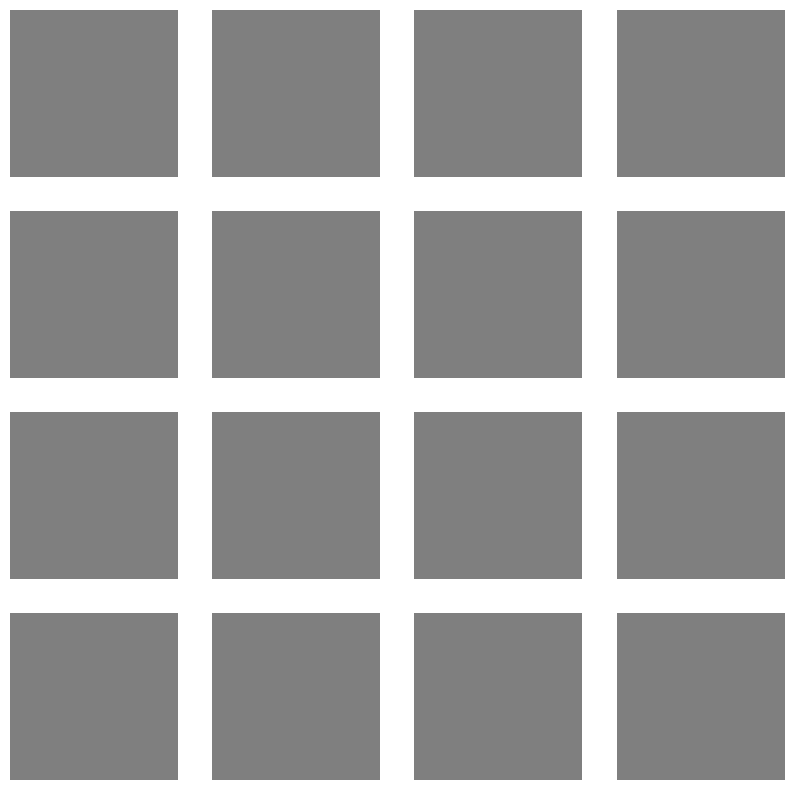

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


In [ ]:
# Train GAN
train_gan(generator, discriminator, data)